In [1]:
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from PIL import Image 
import torchvision.transforms as transforms 
from matplotlib import pyplot as plt

In [4]:
#define the UNet network
class MyUNet(nn.Module):
    def __init__(self):
        super(MyUNet, self).__init__()
        #encoder
        self.down1=nn.Sequential(nn.Conv2d(16, 32, 5, 2, 2, bias=False), nn.LeakyReLU(0.2, inplace=True))
        self.down2=nn.Sequential(nn.Conv2d(32, 64, 5, 2, 2, bias=False), nn.LeakyReLU(0.2, inplace=True))
        self.down3=nn.Sequential(nn.Conv2d(64, 128, 5, 2, 2, bias=False), nn.LeakyReLU(0.2, inplace=True))
        self.down4=nn.Sequential(nn.Conv2d(128, 256, 5, 2, 2, bias=False), nn.LeakyReLU(0.2, inplace=True))

        self.skip128= nn.Sequential(nn.Conv2d(128, 4, 5, 1, 2, bias=False),nn.LeakyReLU(0.2, inplace=True))
        self.skip64= nn.Sequential(nn.Conv2d(64, 4, 5, 1, 2, bias=False),nn.LeakyReLU(0.2, inplace=True))

        self.up4=nn.Sequential(nn.ConvTranspose2d(256, 124, 4, 2, 1, bias=False), nn.LeakyReLU(0.2, inplace=True))
        self.up3=nn.Sequential(nn.ConvTranspose2d(128, 60, 4, 2, 1, bias=False), nn.LeakyReLU(0.2, inplace=True))
        self.up2=nn.Sequential(nn.ConvTranspose2d(64, 32, 4, 2, 1, bias=False), nn.LeakyReLU(0.2, inplace=True))
        self.up1=nn.Sequential(nn.ConvTranspose2d(32, 3, 4, 2, 1, bias=False))
        
    def forward(self,x):
        x1=self.down1(x)
        x2=self.down2(x1)
        x2p=self.skip64(x2)
        x3=self.down3(x2)
        x3p=self.skip128(x3)
        x4=self.down4(x3)
        x5=self.up4(x4)
        x5p=torch.concat([x5,x3p],dim=1)
        x6=self.up3(x5p)
        x6p=torch.concat([x6,x2p],dim=1)
        x7=self.up2(x6p)
        x8=self.up1(x7)
        x9=torch.sigmoid(x8)
        return x9
    

In [19]:
#test with an other version of the network
class MyUNet(nn.Module):
    def __init__(self):
        super(MyUNet, self).__init__()
        # down layers
        self.conv_down_1 = nn.Conv2d(16, 32, kernel_size=5, stride=2, padding=2)
        self.conv_down_2 = nn.Conv2d(32, 64, kernel_size=5, stride=2, padding=2)
        self.conv_down_3 = nn.Conv2d(64, 128, kernel_size=5, stride=2, padding=2, bias=False)
        self.conv_down_4 = nn.Conv2d(128, 256, kernel_size=5, stride=2, padding=2, bias=False)
        # skip layers
        self.conv_skip_1 = nn.Conv2d(128, 4, kernel_size=5, stride=1, padding=2, bias=False)
        self.conv_skip_2 = nn.Conv2d(64, 4, kernel_size=5, stride=1, padding=2, bias=False)
        # up layers
        self.conv_up_4 = nn.ConvTranspose2d(256, 124, kernel_size= 4, stride=2, padding=1)
        self.conv_up_3 = nn.ConvTranspose2d(128, 60, kernel_size= 4, stride=2, padding=1)
        self.conv_up_2 = nn.ConvTranspose2d(64, 32, kernel_size= 4, stride=2, padding=1)
        self.conv_up_1 = nn.ConvTranspose2d(32, 3, kernel_size= 4, stride=2, padding=1)
    
        self.model = nn.ModuleList([
            self.conv_down_1,
            self.conv_down_2,
            self.conv_down_3,
            self.conv_down_4,
            self.conv_skip_1,
            self.conv_skip_2,
            self.conv_up_4,
            self.conv_up_3,
            self.conv_up_2,
            self.conv_up_1
        ])

    def forward(self,x):
        x = nn.functional.leaky_relu(self.conv_down_1(x))
        conv2_activated = nn.functional.leaky_relu(self.conv_down_2(x))
        conv3_activated = nn.functional.leaky_relu(self.conv_down_3(conv2_activated))
        x = nn.functional.leaky_relu(self.conv_down_4(conv3_activated))
        x = torch.concat([nn.functional.leaky_relu(self.conv_up_4(x)), nn.functional.leaky_relu(self.conv_skip_1(conv3_activated))], dim=1)
        x = torch.concat([nn.functional.leaky_relu(self.conv_up_3(x)), nn.functional.leaky_relu(self.conv_skip_2(conv2_activated))], dim=1)
        x = nn.functional.leaky_relu(self.conv_up_2(x))
        x = nn.functional.leaky_relu(self.conv_up_1(x))
        x = torch.sigmoid(x)
        return x

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
myunet = MyUNet()
myunet.to(device)

MyUNet(
  (conv_down_1): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (conv_down_2): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (conv_down_3): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
  (conv_down_4): Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
  (conv_skip_1): Conv2d(128, 4, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
  (conv_skip_2): Conv2d(64, 4, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
  (conv_up_4): ConvTranspose2d(256, 124, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv_up_3): ConvTranspose2d(128, 60, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv_up_2): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv_up_1): ConvTranspose2d(32, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (model): ModuleList(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2), 

In [21]:
#config img to load and other parameters
img_to_load= "testcrop.jpg"
nb_epochs = 1500
loadWeightsFile = False
store_path = "inpainting_gen_img/"+str(nb_epochs)+"_"+img_to_load #denoising_gauss_img
print("store_path: ",store_path)

store_path:  inpainting_gen_img/1500_testcrop.jpg


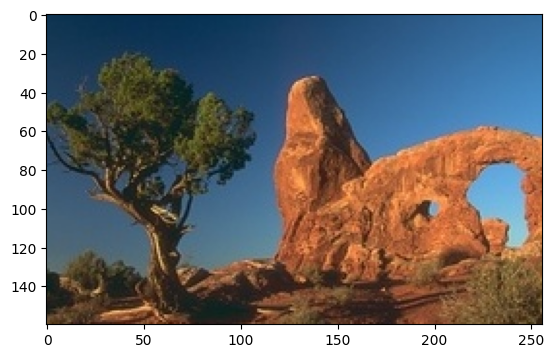

In [22]:
input_img = Image.open(f'src_img/{img_to_load}')
plt.imshow(input_img)
transform = transforms.Compose([transforms.PILToTensor()])
target = transform(input_img)/255
target = target.unsqueeze(0).float().to(device)

# h = target.size()[2]
# w = target.size()[3]
# z = torch.rand(1,16, h, w).to(device)


In [23]:
#Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(myunet.parameters(), lr=0.001) 
losslog = []

In [9]:
import random
#for inpainting : mask random pixel in the image
def mask_image(target,num_noisy_pixels=5000, gaussian_noise = False, mean = 0.0, std = 0.1, color_noising="black"):
    _, height, width = target.shape[1:]

    # Create a mask with all ones (all pixels are initially known)
    mask = torch.ones((1, 3, height, width))

    for _ in range(num_noisy_pixels):
        # Sélectionner des coordonnées aléatoires pour un pixel
        x = random.randint(0, height - 1)
        y = random.randint(0, width - 1)  
        if gaussian_noise:
            # Remplacer la valeur RGB du pixel par du bruit gaussien
            noise = torch.normal(mean, std, size=(3,))
            target[0, :, x, y] += noise    
            # Update the mask to indicate this pixel is unknown
            mask[0, :, x, y] = 0#noise
        else :
            if color_noising=="black":
                # Remplacer les valeurs RGB du pixel par [0, 0, 0] (noir)
                target[0, :, x, y] = torch.tensor([0.0, 0.0, 0.0])
            elif color_noising=="white":
                # Remplacer les valeurs RGB du pixel par [1, 1, 1] (blanc)
                target[0, :, x, y] = torch.tensor([1.0, 1.0, 1.0])
            # Update the mask to indicate this pixel is unknown
            mask[0, :, x, y] = 0
                
    return target, mask

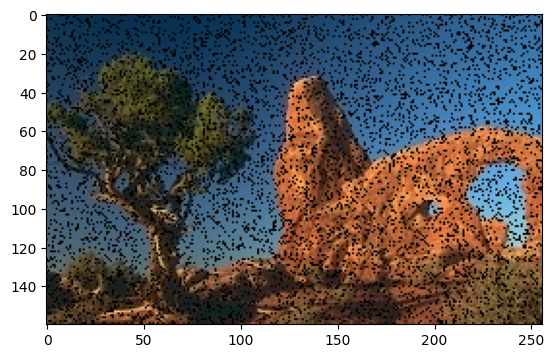

In [24]:
num_noisy_pixels = 7000
gaussian_noise = False
masked_target, mask = mask_image(target, num_noisy_pixels, gaussian_noise = gaussian_noise)
noisy_image = transforms.ToPILImage()(masked_target.squeeze(0))  # Enlever la dimension batch

#show image with plt
plt.imshow(noisy_image)

#store the noising image
noisy_image.save(f"noisy_img/noising_{num_noisy_pixels}.jpg")

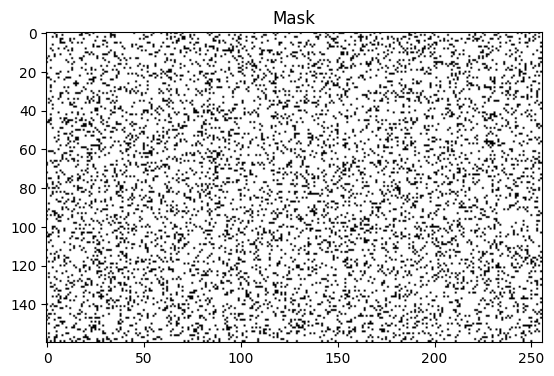

In [130]:
# # Define a custom loss function that only considers known pixels
# def masked_loss(output, target, mask):
#     loss = torch.nn.functional.mse_loss(output*mask, target, reduction='sum')
#     num_known_pixels = mask.sum()
#     return loss / num_known_pixels

# # Example usage of the masked loss function
# loss = masked_loss(target, masked_target, mask)
# print(f"Masked Loss: {loss.item()}")

# Visualize the mask
mask_image = transforms.ToPILImage()(mask.squeeze(0).expand(3, -1, -1))
plt.imshow(mask_image)
plt.title("Mask")
plt.show()

In [25]:
h = masked_target.size()[2]
w = masked_target.size()[3]
z = torch.rand(1,16, h, w).to(device)

In [ ]:
#load the weights
if loadWeightsFile:
    myunet = torch.load(f'weights_pth/weights_{nb_epochs}.pth',weights_only=False)
    print("weights loaded")
else :
    #target = masked_target
    for i in range(nb_epochs):
        optimizer.zero_grad() 
        output = myunet(z)
        # # Ensure the sizes of the tensors match
        # if output.size() != target.size():
        #     output = F.interpolate(output, size=target.size()[2:], mode='bilinear', align_corners=False)
        loss = criterion(output, target*mask) #mask*output
        loss.backward()
        losslog.append(loss.item())
        optimizer.step()
        if i%100 == 0:
            print(f"epoch {i+1}, Loss : ", loss)
    #save the model
    torch.save(myunet, f'weights_pth/weights_{nb_epochs}.pth')

epoch 1, Loss :  tensor(0.0972, grad_fn=<MseLossBackward0>)
epoch 101, Loss :  tensor(0.0388, grad_fn=<MseLossBackward0>)
epoch 201, Loss :  tensor(0.0316, grad_fn=<MseLossBackward0>)
epoch 301, Loss :  tensor(0.0259, grad_fn=<MseLossBackward0>)
epoch 401, Loss :  tensor(0.0227, grad_fn=<MseLossBackward0>)
epoch 501, Loss :  tensor(0.0215, grad_fn=<MseLossBackward0>)
epoch 601, Loss :  tensor(0.0201, grad_fn=<MseLossBackward0>)
epoch 701, Loss :  tensor(0.0189, grad_fn=<MseLossBackward0>)
epoch 801, Loss :  tensor(0.0176, grad_fn=<MseLossBackward0>)
epoch 901, Loss :  tensor(0.0166, grad_fn=<MseLossBackward0>)
epoch 1001, Loss :  tensor(0.0152, grad_fn=<MseLossBackward0>)
epoch 1101, Loss :  tensor(0.0140, grad_fn=<MseLossBackward0>)
epoch 1201, Loss :  tensor(0.0131, grad_fn=<MseLossBackward0>)
epoch 1301, Loss :  tensor(0.0122, grad_fn=<MseLossBackward0>)
epoch 1401, Loss :  tensor(0.0114, grad_fn=<MseLossBackward0>)


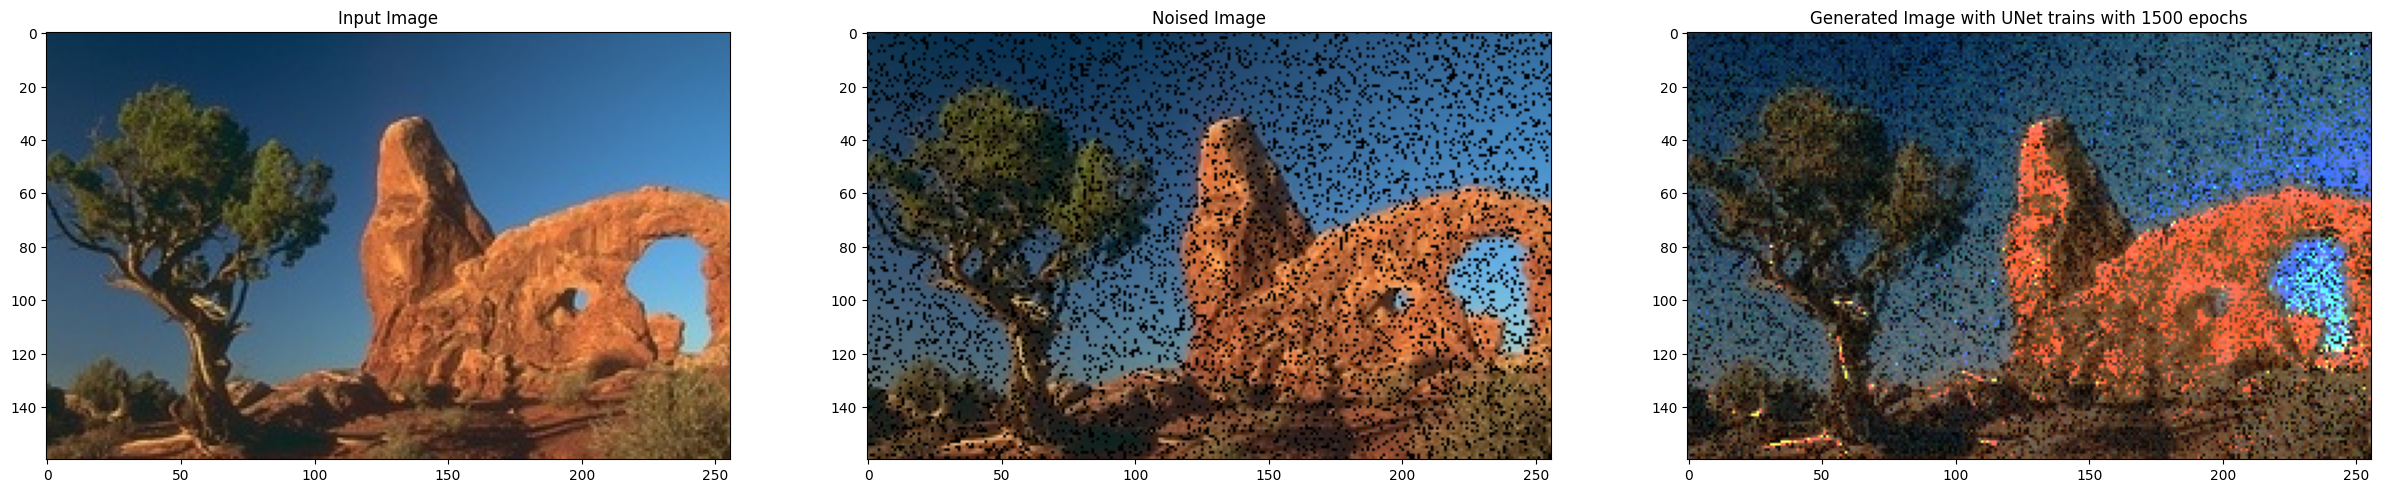

In [27]:
output = myunet(z)
gen_img = output[0].cpu().detach().permute(1,2,0).numpy()    
plt.imsave(store_path, gen_img)
#plot to the right the input_img and to the left the generated image
plt.figure(figsize=(30,30))
plt.subplot(1,3,1)
plt.imshow(input_img)
plt.title("Input Image")
plt.subplot(1,3,2)
plt.imshow(noisy_image)
plt.title("Noised Image")
plt.subplot(1,3,3)
plt.imshow(gen_img)
plt.title(f"Generated Image with UNet trains with {nb_epochs} epochs")
plt.show()

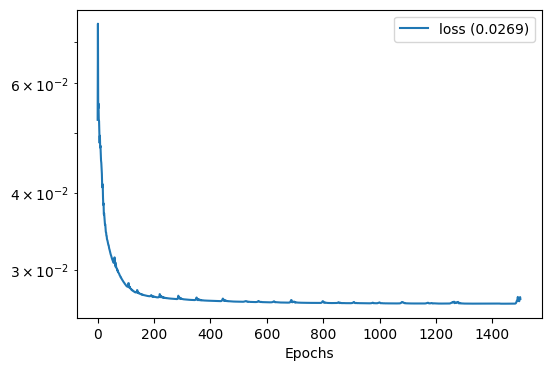

In [129]:
#plot loss function
plt.figure(figsize=(6,4))
plt.yscale('log')
plt.plot(losslog, label = 'loss ({:.4f})'.format(losslog[-1]))
plt.xlabel("Epochs")
plt.legend()
plt.show()
plt.close()

# Test for creating the mask

In [58]:
import torch
import random
from torchvision import transforms
import matplotlib.pyplot as plt

# Example target tensor with shape (1, 3, H, W)
target = torch.randn(1, 3, 64, 64)
print("target shape: ",target.shape)

# Parameters
num_noisy_pixels = 5000
_, height, width = target.shape[1:]

# Create a mask with all ones (all pixels are initially known)
mask = torch.ones((1, 1, height, width))
print("mask shape: ",mask.shape)
print("mask: ",mask)

target shape:  torch.Size([1, 3, 64, 64])
mask shape:  torch.Size([1, 1, 64, 64])
mask:  tensor([[[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]]])


Masked Loss: 5.9474358558654785


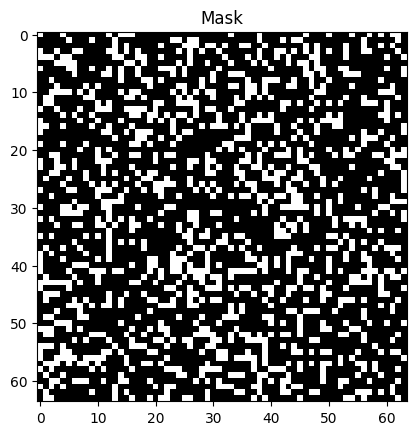

In [59]:
# Mask random pixels
for _ in range(num_noisy_pixels):
    x = random.randint(0, height - 1)
    y = random.randint(0, width - 1)
    # Set the pixel to black (0, 0, 0)
    target[0, :, x, y] = torch.tensor([0.0, 0.0, 0.0])
    # Update the mask to indicate this pixel is unknown
    mask[0, 0, x, y] = 0

# Convert the tensor to a PIL image for visualization
image = transforms.ToPILImage()(target.squeeze(0))
plt.imshow(image)

# Define a custom loss function that only considers known pixels
def masked_loss(output, target, mask):
    loss = torch.nn.functional.mse_loss(output * mask, target * mask, reduction='sum')
    num_known_pixels = mask.sum()
    return loss / num_known_pixels

# Example usage of the masked loss function
output = torch.randn_like(target)  # Example output tensor
loss = masked_loss(output, target, mask)
print(f"Masked Loss: {loss.item()}")

# Visualize the mask
mask_image = transforms.ToPILImage()(mask.squeeze(0).expand(3, -1, -1))
plt.imshow(mask_image, cmap='gray')
plt.title("Mask")
plt.show()